In [1]:
# 최소-최대 정규화

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [2]:
print(train_data.shape)
print(heldout_data.shape)
print(test_data.shape)

(12968, 21)
(4323, 21)
(4322, 21)


In [3]:
# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [4]:
print(train_data.iloc[0:2, [0,1,2,3]])
print(heldout_data.iloc[0:2, [0,1,2,3]])
print(test_data.iloc[0:2, [0,1,2,3]])

           id             date     price  bedrooms
0  1310440590  20150413T000000  440000.0         3
1  1437580480  20140918T000000  994000.0         5
           id             date     price  bedrooms
0  7229800175  20140604T000000  453500.0         5
1  3905080870  20150206T000000  510000.0         3
           id             date  price  bedrooms
0  7000100850  20140926T000000    NaN         4
1  4037400280  20140923T000000    NaN         3


In [5]:
# yr
yr_sum = train_data.yr_built + train_data.yr_renovated
yr_sum.apply(lambda x : x / 2 if x > 3000 else x)
train_data = train_data.drop(['yr_built','yr_renovated'], axis=1)
train_data['yr'] = yr_sum.apply(lambda x : x / 2 if x > 3000 else x)

yr_sum = heldout_data.yr_built + heldout_data.yr_renovated
yr_sum.apply(lambda x : x / 2 if x > 3000 else x)
heldout_data = heldout_data.drop(['yr_built','yr_renovated'], axis=1)
heldout_data['yr'] = yr_sum.apply(lambda x : x / 2 if x > 3000 else x)

yr_sum = test_data.yr_built + test_data.yr_renovated
yr_sum.apply(lambda x : x / 2 if x > 3000 else x)
test_data = test_data.drop(['yr_built','yr_renovated'], axis=1)
test_data['yr'] = yr_sum.apply(lambda x : x / 2 if x > 3000 else x)

In [6]:
# 'zipcode', 'long', 'sqft_lot', 'condition', 'sqft_lot15', 'yr' 제거
elist = ['zipcode', 'long', 'condition']
train_data = train_data.drop(elist, axis=1)
heldout_data = heldout_data.drop(elist, axis=1)
test_data = test_data.drop(elist, axis=1)

In [15]:
def minmax_norm(df_input):
    return (df_input - df_input.min()) / ( df_input.max() - df_input.min())

In [16]:
nor_train = minmax_norm(train_data.iloc[:, 3:-1])
nor_heldout = minmax_norm(heldout_data.iloc[:, 3:-1])
nor_test = minmax_norm(test_data.iloc[:, 3:-1])

nor_train_price = minmax_norm(train_data.iloc[:, 2:3])
nor_heldout_price = minmax_norm(heldout_data.iloc[:, 2:3])

In [17]:
train_label_max, train_label_min = train_data.iloc[:, 2].max(), train_data.iloc[:, 2].min()
heldout_label_max, heldout_label_min = heldout_data.iloc[:, 2].max(), heldout_data.iloc[:, 2].min()
print(train_label_max, train_label_min)
print(heldout_label_max, heldout_label_min)

uni_label_max = pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2])).max()
uni_label_min = pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2])).min()
print(uni_label_max, uni_label_min)

7062500.0 80000.0
4668000.0 75000.0
7062500.0 75000.0


In [18]:
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
train_labels = torch.tensor(nor_train_price.values.reshape(-1, 1), dtype=torch.float32)

heldout_feats = torch.tensor(nor_heldout.iloc[:, :].values, dtype=torch.float32)
heldout_labels = torch.tensor(nor_heldout_price.values.reshape(-1, 1), dtype=torch.float32)

test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

In [19]:
print(train_feats.shape)
print(train_labels.shape)
print(heldout_feats.shape)
print(heldout_labels.shape)
print(test_feat.shape)

torch.Size([12968, 13])
torch.Size([12968, 1])
torch.Size([4323, 13])
torch.Size([4323, 1])
torch.Size([4322, 13])


In [20]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]


class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.fc2 = nn.Linear(32, 40)
        self.fc3 = nn.Linear(40, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
#         self.relu = nn.ReLU() # trial 5
        self.relu = nn.PReLU() # trial 3, 6
#         self.relu = nn.SELU() # trial 4, 7
#         self.relu = nn.Tanh() # trial 8
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.relu(x)
#         x = self.dropout(x) # trial 2 유 / 5,6,7 무
        
        x = self.fc5(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [21]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 256
epochs = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0, weight_decay=weight_decay, initial_accumulator_value=0, eps=1e-10)

In [22]:
train_features, train_labels  = train_feats.to(device), train_labels.to(device)
test_features, test_labels = heldout_feats.to(device), heldout_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_ls, test_ls = [], []

for epoch in range(800):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    train_rmse = np.sqrt(criterion(net(train_features), train_labels).item())
    test_rmse = np.sqrt(criterion(net(test_features), test_labels).item())
    
    train_ls.append(train_rmse)
    test_ls.append(test_rmse)

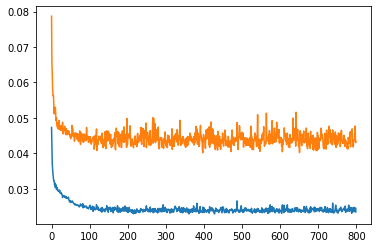

0.0235, 0.0434


In [23]:
plt.plot(train_ls)
plt.plot(test_ls)
plt.show()

print(f'{train_ls[-1]:0.4f}, {test_ls[-1]:0.4f}')

In [24]:
predicts = net(test_features).to('cpu').detach().numpy()

train_predicts = predicts * (train_label_max - train_label_min) + train_label_min
held_predicts = predicts * (heldout_label_max - heldout_label_min) + heldout_label_min
uni_predicts = predicts * (uni_label_max - uni_label_min) + uni_label_min

rmse_train = rmse(train_predicts, heldout_data.iloc[:, [2]].values)
rmse_held = rmse(held_predicts, heldout_data.iloc[:, [2]].values)
rmse_uni = rmse(uni_predicts, heldout_data.iloc[:, [2]].values)

print(rmse_train)
print(rmse_held)
print(rmse_uni)

286121.9394996176
210745.3879929762
284091.49847189174
